### Intermediate Deliverable 2

- $I=\{DSO545-16278,DSO528-16274,....\}$ Course+Section
- $Im=\{DSO433-16227,DSO516-16305,....\}$ Course+Section that takes place in multiple days of the week
- $J=\{JKP102,JKP104,...\}$ Room
- $K=\{M, T, W, H, F, S, U\}$ Day of the week from Monday to Sunday
- $Ki=$ days of the week that course+section i takes place
- $L=\{0,1,...,14\}$ index of the time slot of each day from 10:00 to 17:00; each time slot is 30 mins.
- Let decision variables be $x_{ijkl}$ to denote whether course+section $i \in I$ assigned to room $j \in J$ on day $k \in K$ at time slot $l \in L$.
- Let $S_{i}$ denote the number of registered students for course+section $i \in I$.
- Let $C_{j}$ denote the capacity of room $j \in J$.
- Let $u_{i}$ denote the total number of slots needed for course+section $i \in I$ for one day. For example, for a 3-hour class, a total of 6 slots is needed; for a 1.5-hour class, a total of 3 slots is needed for a single day.
- Let auxiliary decision variable $U_{ijk}$ corresponding to an upper bound of $x_{ijkl}$'s that belong to the same course+section $i$, room $j$ and day $k$. For example, for course+section $i$, $U_{ijk}$ would be 1 if any of the slots at room $j$ on day $k$ is filled.
- Let $Y_{ik}=\{0,1\}$ denote whether course+section $i$ takes place on day $k$.

$$\begin{aligned}
\text{maximize} && \sum_{i \in I}\sum_{j \in J}\sum_{k \in K}\sum_{l \in L} x_{ijkl}* \frac{S_{i}}{C_{j}}\\\
\text{classroom capacity constraint}&& \ x_{ijkl}*S_{i} \le 0.9*C_{j} & \qquad \text{for all $j \in J$}&\\
\text{day of week constraint}&& \sum_{j \in J}\sum_{l \in L} x_{ijkl} = u_{i}*Y_{ik} & \qquad \text{for all $i \in I$, $k \in K$}&\\
\text{one course constraint}&& \sum_{i \in I} x_{ijkl} \le 1 & \qquad \text{for all $j \in J$, $k \in K$, $l \in L$}&\\
\text{unique room + time slots constraint}&& \sum_{j \in J} x_{ijkl} \le 1 & \qquad \text{for all $i \in I$, $k \in K$, $l \in L$}&\\
\text{}&& \ x_{ijkl} \le U_{ijk} & \qquad \text{for all $i \in I$, $j \in J$, $k \in K$, $l \in L$}&\\
\text{}&& \sum_{l \in L} x_{ijkl} = u_{i}*U_{ijk} & \qquad \text{for all $i \in I$,  $j \in J$, $k \in K$}&\\
\text{consecutive slots constraint}&& \ x_{ijkl} + x_{ijkl'} \le 1 & \qquad \text{for all $i \in I$, $j \in J$, $k \in K$, $l \in L$ except for the last $u_{i}$ $l$s, $l' \ge l+u_{i}-1$} &\\
\text{same slots for multiple-day class constraint}&& \ x_{ijkl} = x_{ij(k+1)l} & \qquad \text{for all $i \in Im$, $j \in J$, $k \in Ki$ except the last k, $l \in L$}&\\
\text{instructor constraint}&& \  & \qquad \text{for all $i \in Im$, $j \in J$, $k \in Ki$ except the last k, $l \in L$}&\\
\end{aligned}$$

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math

file_name = 'small_data'
data = pd.ExcelFile('{}.xlsx'.format(file_name))

courses = data.parse(0, parse_dates=True) #Courses  #pd.read_excel('{}.xlsx'.format(file_name), sheet_name='Course_Enrollment', parse_dates=False)#
courses = courses.set_index(['Course', 'Section'])

rooms = data.parse(1) #Rooms
rooms = rooms.set_index('Room')

#students = data.parse(2) #Students

#AM8:00~PM10:00 total 14 hours, 28 time slots 
#For deliverable 2, we will only use prime time AM10:00~PM5:00 14 slots
slots_per_day = 28
#num_days = 7

I = courses.index #Course name and section (tuple)
J = rooms.index #Room ID
K = ['M', 'T', 'W', 'H', 'F', 'S', 'U']
L = range(0,slots_per_day) #Time slot ID

Ki = courses.loc[:,'First Days']

s = courses.loc[:,'Reg Count'] #Registration Count
c = rooms.Size #Room Capacity
UIDs = courses.loc[:,'First Instructor UID']

#Convert time difference to 30 mins unit slot: 3 h = 6 slots, 1 h 20 m = 3 slots
u2 = pd.to_datetime(courses.loc[:,'First End Time'].astype(str))#.apply(datetime)
u1 = pd.to_datetime(courses.loc[:,'First Begin Time'].astype(str))
u = ((u2-u1).apply(timedelta.total_seconds)/1800).apply(math.ceil).astype(int)

courses.describe()

/Users/simba/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/io/excel.py:380: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"


,Course Suffix,First Instructor UID,Link,Max Units,Min Units,Reg Count,Seats,Second Begin Time,Second Days,Second End Time,Second Instructor UID,Second Room,Session,Term
count,33.000000,3.200000e+01,0.0,33.000000,33.000000,33.000000,33.000000,0.0,0.0,0.0,3.000000e+00,0.0,33.000000,33.0
mean,524.060606,4.388750e+09,NaN,2.606061,2.606061,34.575758,50.454545,NaN,NaN,NaN,4.534623e+09,NaN,112.696970,20171.0
std,64.953801,2.835978e+09,NaN,0.798021,0.798021,13.174384,13.603977,NaN,NaN,NaN,2.970788e+09,NaN,179.446281,0.0
min,401.000000,1.199754e+09,NaN,1.000000,1.000000,5.000000,32.000000,NaN,NaN,NaN,2.819438e+09,NaN,1.000000,20171.0
25%,510.000000,2.146042e+09,NaN,2.000000,2.000000,27.000000,40.000000,NaN,NaN,NaN,2.819438e+09,NaN,33.000000,20171.0
50%,530.000000,3.550296e+09,NaN,3.000000,3.000000,35.000000,50.000000,NaN,NaN,NaN,2.819438e+09,NaN,33.000000,20171.0
75%,580.000000,6.113056e+09,NaN,3.000000,3.000000,43.000000,54.000000,NaN,NaN,NaN,5.392216e+09,NaN,33.000000,20171.0
max,621.000000,9.778663e+09,NaN,4.000000,4.000000,55.000000,78.000000,NaN,NaN,NaN,7.964993e+09,NaN,640.000000,20171.0


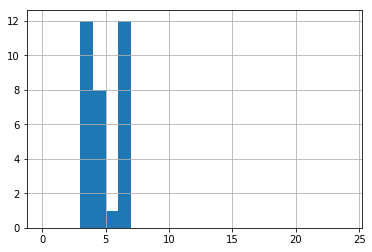

In [3]:
import matplotlib.pyplot as plt

u.hist(bins=range(25))
plt.show()

In [38]:
import gurobipy as grb


mod=grb.Model()

#Variable Definition
x={} #binary variable whether the course is assigned to each room at each time slot of each day
U={} #Maximum value of all slots for that day for each course and each room
for i in I:
    for j in J:
        for k in K:
            U[i,j,k]=mod.addVar(vtype=grb.GRB.BINARY, name='U[{0},{1},{2}]'.format(i,j,k)) #vtype=grb.GRB.BINARY,
            for l in L:
                x[i,j,k,l]=mod.addVar(vtype=grb.GRB.BINARY,name='x[{0},{1},{2},{3}]'.format(i,j,k,l))

#Classroom capacity constraint
for i in I:
    for j in J:
        for k in Ki[i][:1]:
            for l in L:
                mod.addConstr(x[i,j,k,l]*s[i] <= 0.9*c[j])
                
#Day of week constraint
for i in I:
    for k in K:
        if k not in Ki[i]:
            mod.addConstr(sum(x[i,j,k,l] for j in J for l in L)==0)
        else:
            mod.addConstr(sum(x[i,j,k,l] for j in J for l in L)==u[i])

#One course constraint
for j in J:
    for k in K:
        for l in L:
            mod.addConstr(sum(x[i,j,k,l] for i in I) <= 1)

#Unique room constraint
#for i in I:
#    for k in K:
#        for l in L:
#            mod.addConstr(sum(x[i,j,k,l] for j in J) <= 1)
            
for i in I:
    for j in J:
        for k in K:
            for l in L:
                mod.addConstr(x[i,j,k,l] <= U[i,j,k])
            mod.addConstr(sum(x[i,j,k,l] for l in L) == u[i]*U[i,j,k])
            
#Consecutive constraint
for i in I:
    for j in J:
        for k in Ki[i][:1]:
            for l in L:
                if l + u[i]-1 < len(L) - 1:
                    for m in range(l + u[i], len(L)):
                        mod.addConstr(x[i,j,k,l] + x[i,j,k,m] <= 1)

#Same instuctor constraint

for k in K:
    for l in L:
        for uid in np.unique(UIDs.values[~np.isnan(UIDs.values)]):
            I_uid = (UIDs == uid)
            mod.addConstr(sum(x[i,j,k,l] for i in I.values[I_uid] for j in J) <= 1)
                
#Same slot of day constraint for multiple days
for i in I:
    if len(Ki[i]) > 1:
        for j in J:
            for index, k in enumerate(Ki[i]):
                if index < len(Ki[i])-1:
                    for l in L:
                        mod.addConstr(x[i,j,Ki[i][index],l]==x[i,j,Ki[i][index+1],l])


#Objective function
mod.setObjective(sum(x[i,j,k,l]*s[i]/c[j] for i in I for j in J for k in K for l in L) , sense=grb.GRB.MAXIMIZE)

#Optimize
mod.optimize()
print('Optimal Objective:', mod.ObjVal)

Optimize a model with 182549 rows, 66990 columns and 598870 nonzeros
Variable types: 0 continuous, 66990 integer (66990 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [7e-02, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 175147 rows and 63368 columns
Presolve time: 1.13s
Presolved: 7402 rows, 3622 columns, 55006 nonzeros
Variable types: 0 continuous, 3622 integer (3622 binary)
Found heuristic solution: objective 141.4311615

Root relaxation: objective 1.497151e+02, 8036 iterations, 0.97 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     149.7150611  149.71506  0.00%     -    2s

Explored 0 nodes (8682 simplex iterations) in 2.48 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 149.715 141.431 

Optimal solution found (tolerance 1.00e-04)
B

In [39]:
#Save output
outTable0 = {}
col = []

data_room = []
data_time = []
for i in I:    
    Room_id = ''
    Start_time = 0
    for k in Ki[i][:1]:
        for j in J:
            if int(U[i,j,k].x) == 1 :                
                Room_id = j
                for l in L:
                    if x[i,j,k,l].x == 1 :
                        Start_time = l
                        break
                                    
    data_room.append(Room_id)
    data_time.append(Start_time)

outTable0['Room'] = data_room
outTable0['Day'] = Ki.values
outTable0['30m Slots'] = u.values
outTable0['UID'] = UIDs.values

data_time_ = [datetime(year=2018, month=5, day=1, hour=8) + timedelta(minutes=30*data_time[i]) for i in range(len(I))]
outTable0['Start Time'] = [data_time_[i].strftime("%I:%M%p") for i in range(len(I))]
outTable0['End Time'] = [(data_time_[i] + timedelta(minutes=30*u[i])).strftime("%I:%M%p") for i in range(len(I))]

outDf0 = pd.DataFrame(outTable0, index=I)
outDf0 = outDf0[['UID', 'Room', 'Day', '30m Slots', 'Start Time', 'End Time']]

outTable1={}
time_slot = 0
#outTable1['Units(Input)'] = u.values * Ki.apply(len) /2
#units_calc = []

#for i in I: 
#    units_calc_ = 0
#    for j in J:
#        for k in K:
#            for l in L:
#                units_calc_ += x[i,j,k,l].x
#    units_calc.append(units_calc_/2)
#outTable1['Units(Calculated)'] = units_calc
#outDf1 = pd.DataFrame(outTable1, index=I)

outTable1 = {}
col = []
for k in K:
    for l in L:
        data = []
        for i in I:    
            Room_id = ''
            for j in J:
                if x[i,j,k,l].x == 1 :
                    Room_id = j
                    break
            data.append(Room_id)
            
        outTable1[(k,l)] = data
        col.append((k,l))
#        time_slot += 1

#outDf1 = pd.concat([outDf1, pd.DataFrame(outTable1, index=I)[col]], axis=1)
outDf1 = pd.DataFrame(outTable1, index=I)
outDf1 = outDf1[col]

outTable2={}
time_slot = 0
for k in K:
    for l in L:
        data = []
        for j in J:    
            course_id = ''
            for i in I:
                if x[i,j,k,l].x == 1 :
                    course_id = "{}-{}:{}".format(i[0],i[1],s[i])
                    break
            data.append(course_id)
            
        outTable2[(k,l)] = data
#        time_slot += 1

outDf2 = pd.DataFrame(outTable2, index=[J,c])
outDf2 = outDf2[col]

writer = pd.ExcelWriter('output_of_{}.xlsx'.format(file_name))
outDf0.to_excel(writer,'Result')
outDf1.to_excel(writer,'Course')
outDf2.to_excel(writer,'Room')
writer.save()
print('done')

done


In [20]:
from datetime import time
timedelta(minutes=30*4)
dd = datetime(year=1981, month=8, day=31, hour=8) + timedelta(minutes=30*4)
dd.strftime("%I:%M%p")
U

{((u'DSO-599', 16318),
  u'BRI202A',
  'F'): <gurobi.Var U[(u'DSO-599', 16318),BRI202A,F] (value 0.0)>,
 ((u'DSO-516', 16305),
  u'HOH506',
  'W'): <gurobi.Var U[(u'DSO-516', 16305),HOH506,W] (value 0.0)>,
 ((u'DSO-582', 16289),
  u'JFF LL102',
  'H'): <gurobi.Var U[(u'DSO-582', 16289),JFF LL102,H] (value 0.0)>,
 ((u'DSO-510', 16304),
  u'JFF LL101',
  'F'): <gurobi.Var U[(u'DSO-510', 16304),JFF LL101,F] (value 0.0)>,
 ((u'DSO-530', 16275),
  u'BRI8',
  'W'): <gurobi.Var U[(u'DSO-530', 16275),BRI8,W] (value 0.0)>,
 ((u'DSO-586', 16330),
  u'HOH1',
  'U'): <gurobi.Var U[(u'DSO-586', 16330),HOH1,U] (value 0.0)>,
 ((u'DSO-599', 16318),
  u'HOH2',
  'S'): <gurobi.Var U[(u'DSO-599', 16318),HOH2,S] (value 0.0)>,
 ((u'DSO-401', 16214),
  u'HOH706',
  'U'): <gurobi.Var U[(u'DSO-401', 16214),HOH706,U] (value 0.0)>,
 ((u'DSO-599', 16317),
  u'BRI202A',
  'M'): <gurobi.Var U[(u'DSO-599', 16317),BRI202A,M] (value 0.0)>,
 ((u'DSO-580', 16286),
  u'JFF LL103',
  'M'): <gurobi.Var U[(u'DSO-580', 1628